# Training Bio-OFC on the Gym-Fly environment

### Training 
This can take a bit of time. A saved model is available in the saves folder.
Running the following lines will not overwrite the saved model.

In [1]:
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

100%|██████████| 30000/30000 [1:38:20<00:00,  5.08it/s, cost=0.853, ep_len=1008, pi_lr=4e-10, sid_err=0.016, sid_lr=6.1e-10] 


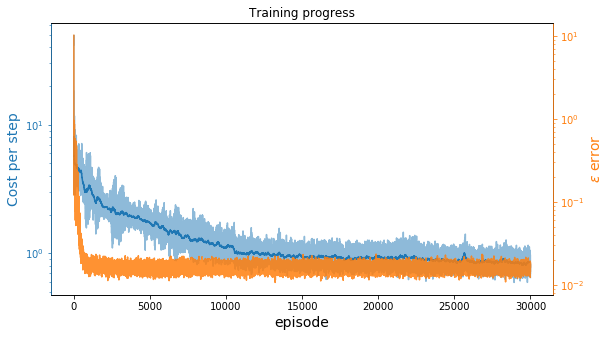

In [73]:
import gym, numpy as np, copy, time, matplotlib.pyplot as plt, tqdm, pickle as pkl
from bio_ofc import *

env_fn = lambda : gym.make('gym_fly:fly-v1')

ABCKL, (cost_hist, ll_hist, ep_len_hist, ABCKL_hist) = bio_ofc_train(env_fn = env_fn,
                                ABCKL = None,
                                internal_dim = 5,
                                bias_value = 0.2,
                                seed=0,
                                max_ep_len=lambda ep: np.int(np.clip(200 + (1000-200)*ep/500,0,1000)),
                                episodes=30000,
                                sid_lr=lambda ep: 2e-3*np.exp(-ep/2000) ,
                                pi_lr=4e-10,
                                sigma = 0.1,
                                chckpnt_eps = np.int_(np.linspace(0,30000,1001)))

pkl.dump( [ABCKL, (cost_hist, ll_hist, ep_len_hist, ABCKL_hist) ], 
                                     open(  "./saves/bio_ofc_flyv1/BV_0.2_new", "wb" ) )

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,5))
colors = ['tab:blue','tab:orange']; fs = 14;
ch = np.array(cost_hist)
ax.semilogy(ch, alpha = 0.5);
ax.semilogy([ch[-100+i:i].mean() for i in range(100,len(ch))], color = colors[0]);
ax.set_ylabel('Cost per step',fontsize=fs, color=colors[0]);
ax.tick_params(axis='y', colors=colors[0], which='both')
ax2 = ax.twinx()
ax2.semilogy(ll_hist, color=colors[1], alpha=0.85);
ax2.set_ylabel('$\epsilon$ error',fontsize=fs, color=colors[1]);
ax2.tick_params(axis='y', colors=colors[1], which='both')
ax2.spines['left'].set_color(colors[0])
ax2.spines['right'].set_color(colors[1])
ax.set_title('Training progress')
ax.set_xlabel('episode',fontsize=fs);

### Evaluation
This loads the saved model. To load the new model saved above (if training a new model), change the filename from BV_0.2 to BV_0.2_new.

In [1]:
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import gym, numpy as np, copy, time, matplotlib.pyplot as plt, tqdm, pickle as pkl
from matplotlib.pyplot import cm
from bio_ofc import *

ABCKL, _ = pkl.load( open(  "./saves/bio_ofc_flyv1/BV_0.2", "rb" )  )

#### Performance - rendering the environment

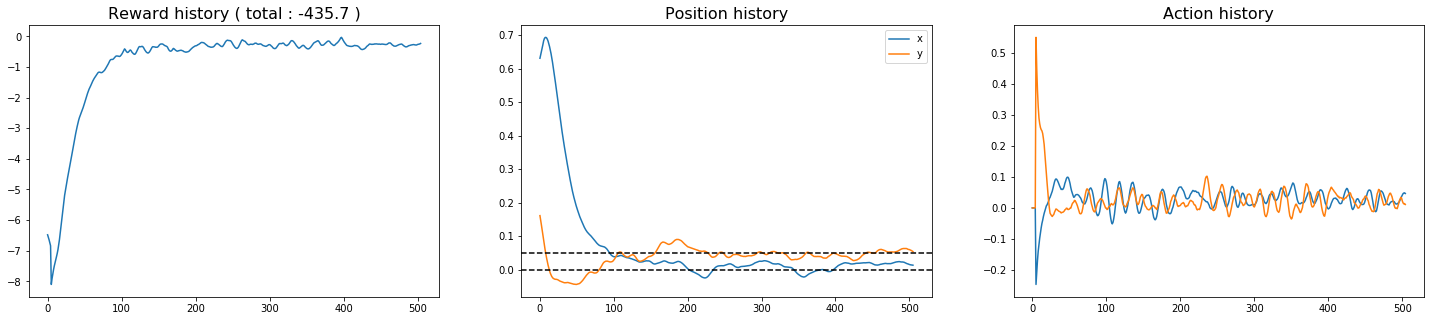

In [2]:
env_fn = lambda : gym.make('gym_fly:fly-v1')

Y, Xh, U, cost_hist, e = bio_ofc_eval(env_fn, ABCKL, bias_value = .2,
                                      tag = '', ep_len = 500, seed=0, render=False)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5)); axes = axes.flatten()

axes[0].plot(-np.array(cost_hist), color='tab:blue');
axes[0].set_title('Reward history ( total : {:.1f} )'.format(-np.sum(cost_hist)), fontsize=16)

axes[1].plot(Y[:,0], label='x'); axes[1].set_title('Position history', fontsize=16);
axes[1].plot(Y[:,1], label='y'); axes[1].legend()
axes[1].axhline(0, color='black', linestyle='dashed')
axes[1].axhline(env_fn().target_y, color='black', linestyle='dashed')

axes[2].plot(U); axes[2].set_title('Action history', fontsize=16);

#### Trajectories in absence of noise

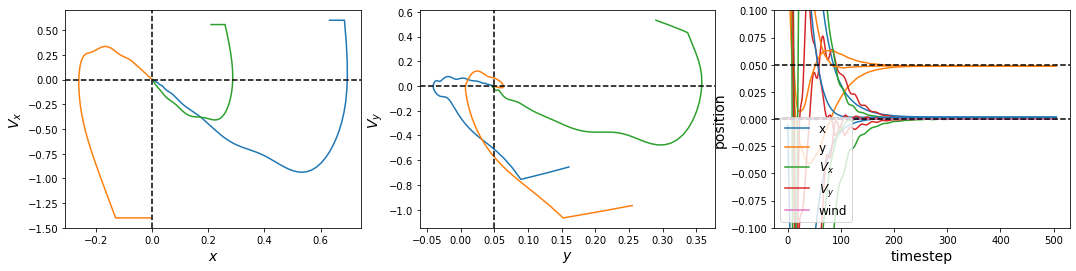

In [3]:
def no_noise_env_fn():
    env = gym.make('gym_fly:fly-v1')
    env.noise_scale = 0
    env.wind_scale = 0
    return env

labels = ['x', 'y', '$V_x$', '$V_y$', None, None,'wind']

num_eps = 3; Ys = []
for ep in range(num_eps):
    Y, Xh, U, cost_hist, e = bio_ofc_eval(no_noise_env_fn, ABCKL, bias_value = .2,
                                      tag = '', ep_len = 500, seed=ep, render=False)
    Ys.append(Y)
    
Ys = np.array(Ys)
plt.figure(figsize=(18,4));
plt.subplot(1,3,1)
plt.plot(Ys[:,:,0].T,Ys[:,:,2].T);
[f(0, color='black', linestyle='dashed') for f in [plt.axhline,plt.axvline]];
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$V_x$', fontsize=14)
plt.subplot(1,3,2)
plt.plot(Ys[:,:,1].T,Ys[:,:,3].T);
[f(loc, color='black', linestyle='dashed') for f,loc in [(plt.axvline,no_noise_env_fn().target_y),(plt.axhline,0)]];
plt.xlabel('$y$', fontsize=14)
plt.ylabel('$V_y$', fontsize=14);
plt.subplot(1,3,3);
for i_, trial in enumerate(Ys):
    for coord in range(trial.shape[1]):
        label = labels[coord] if i_ == 0 else None
        plt.plot(trial[:,coord], color=cm.tab10(coord), label = label)
plt.legend(fontsize=12, loc=3)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('position', fontsize=14);
plt.axhline(0, color='black', linestyle='dashed');
plt.axhline(no_noise_env_fn().target_y, color='black', linestyle='dashed');
plt.ylim(-0.1,0.1);

## Paper plot

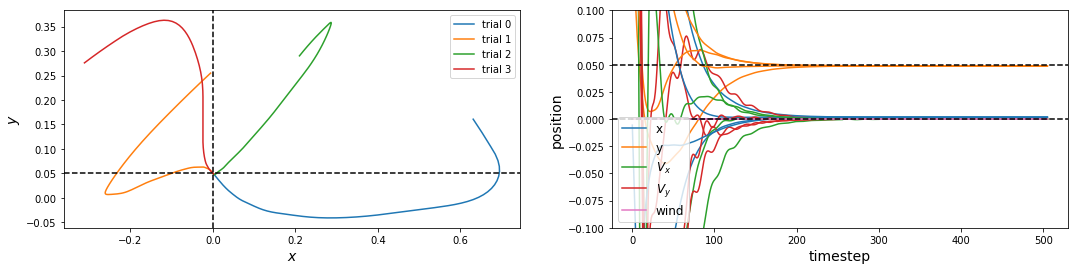

In [4]:
def no_noise_env_fn():
    env = gym.make('gym_fly:fly-v1')
    env.noise_scale = 0
    env.wind_scale = 0
    return env

labels = ['x', 'y', '$V_x$', '$V_y$', None, None,'wind']

num_eps = 4; Ys = []
for ep in range(num_eps):
    Y, Xh, U, cost_hist, e = bio_ofc_eval(no_noise_env_fn, ABCKL, bias_value = .2,
                                      tag = '', ep_len = 500, seed=ep, render=False)
    Ys.append(Y)
    
Ys = np.array(Ys)
plt.figure(figsize=(18,4));
plt.subplot(1,2,1)
for j, trial in enumerate(Ys):
    plt.plot(trial[:,0].T,trial[:,1].T, label='trial {}'.format(j));
plt.axvline(0, color='black', linestyle='dashed');
plt.axhline(no_noise_env_fn().target_y, color='black', linestyle='dashed');
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()

plt.subplot(1,2,2);
for i_, trial in enumerate(Ys):
    for coord in range(trial.shape[1]):
        label = labels[coord] if i_ == 0 else None
        plt.plot(trial[:,coord], color=cm.tab10(coord), label = label)
plt.legend(fontsize=12, loc=3)
plt.xlabel('timestep', fontsize=14)
plt.ylabel('position', fontsize=14);
plt.axhline(0, color='black', linestyle='dashed');
plt.axhline(no_noise_env_fn().target_y, color='black', linestyle='dashed');
plt.ylim(-0.1,0.1);

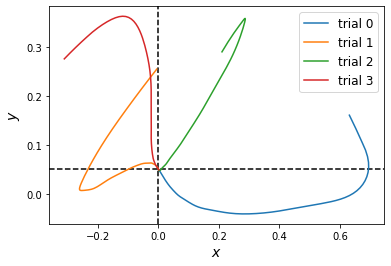

In [5]:
plt.axvline(0, color='black', linestyle='dashed');
plt.axhline(no_noise_env_fn().target_y, color='black', linestyle='dashed');
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
for j, trial in enumerate(Ys):
    plt.plot(trial[:,0].T,trial[:,1].T, label='trial {}'.format(j));
# plt.figaspect(5)
plt.legend(fontsize=12);
plt.yticks(np.arange(0,4)/10);